In [131]:
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import imageio

import pandas as pd

%matplotlib inline

### Data preprocessing

In [132]:
# # Read the data and cocatanate the data frame

# # Read two CSV files which includes joint angle and EMG features

# # For joint angle estimation
# path = r'D:\GitHub\EMG_regressive_model\data\2'
# all_files = glob.glob(path + "/*csv")
# print(all_files)

# dfList = []

# for filename in all_files:
#     df = pd.read_csv(filename)
#     df.head()
#     dfList.append(df)
# frame = pd.concat(dfList, axis = 1, ignore_index = False)
# frame.head()

In [133]:
# For load estimation

path = r'D:\GitHub\EMG_regressive_model\data\2'
all_files = glob.glob(path + "/*csv")
dfList = []

for filename in all_files:
    df = pd.read_csv(filename)
    df.head()
    dfList.append(df)
frame = pd.concat(dfList, axis = 1, ignore_index = False)
frame.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,joint_angle
0,0.000000,0.000000,0.000017,0.001201,0.000000,0.002466,2.690000e-06,0.000000e+00,0.000011,0.25,0.666667,0.0,0.5,1.0,0.0,1.195211
1,0.001852,0.000148,0.001041,0.004637,0.000448,0.013558,2.840000e-05,4.030000e-07,0.000208,0.00,0.000000,0.0,0.0,0.0,0.5,1.190142
2,0.004361,0.000536,0.010023,0.003521,0.000924,0.017291,1.720000e-05,5.460000e-07,0.000349,0.00,0.333333,0.0,0.0,0.0,0.0,1.185074
3,0.005189,0.000417,0.008359,0.000692,0.002204,0.025504,8.370000e-07,4.080000e-06,0.000714,0.25,0.333333,0.0,0.0,0.5,0.0,1.180009
4,0.003663,0.000805,0.008346,0.004482,0.005426,0.041961,2.580000e-05,3.220000e-05,0.001778,0.00,0.000000,0.0,0.0,0.5,0.5,1.174926


In [134]:
# sns.countplot(x = 'load', data=frame)

In [135]:
# create input and output data
x = frame.iloc[:, 0:-1]
y = frame.iloc[:, -1]

# split the data into train, validate, and test set
# because there is a class imblance, should use the stratify opton to make each set has identical distribution
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

In [136]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [137]:
# def get_load_distribution(obj):
#     count_dict = {
#         'load_1': 0,
#         'load_2': 0,
#         'load_3': 0,
#     }
#     for i in obj:
#         if i == 5.5:
#             count_dict['load_1'] += 1
#         elif i == 8.88:
#             count_dict['load_2'] += 1
#         elif i == 11.1:
#             count_dict['load_3'] += 1
#         else:
#             print('Check load labels')
#     return count_dict
# fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 7))

# #Train
# sns.barplot(data=
#            pd.DataFrame.from_dict([get_load_distribution(y_train)]).melt(),
#            x = 'variable',
#            y = 'value',
#            hue = 'variable',
#            ax = axes[0]).set_title('Class distribution in train set')

# #Validation
# sns.barplot(data=
#            pd.DataFrame.from_dict([get_load_distribution(y_val)]).melt(),
#            x = 'variable',
#            y = 'value',
#            hue = 'variable',
#            ax = axes[1]).set_title('Class distribution in validation set')

# #Test
# sns.barplot(data=
#            pd.DataFrame.from_dict([get_load_distribution(y_test)]).melt(),
#            x = 'variable',
#            y = 'value',
#            hue = 'variable',
#            ax = axes[2]).set_title('Class distribution in test set')


In [138]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

### Setup the Neural Network

In [139]:
#Reproducible
torch.manual_seed(1)

### Check whether the GPU is available

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [141]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.x_data)

In [142]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(),
                                 torch.from_numpy(y_train).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(),
                                torch.from_numpy(y_test).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(),
                               torch.from_numpy(y_val).float())

### Build the feedforward neural network

In [143]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
    
    def predict(self, test_inputs):
        x = self.relu(self.fc1(test_inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
        
        

In [144]:
EPOCHS = 150
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_FEATURES = len(x.columns)

In [145]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [146]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

MultipleRegression(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [147]:
# Define a dictionary which will store the loss / epoch for both train and validation sets
loss_stats = {
    'train':[],
    'val':[]
}

### Train the network

In [150]:
print('=========Begin Training=========')
for e in tqdm(range(1, EPOCHS+1)):
    
    #TRAINING
    train_epoch_loss = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
    
    #VALIDATION
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['val'].append(val_epoch_loss / len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    
    

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

=========Begin Training=========


  1%|▌                                                                                 | 1/150 [00:01<03:15,  1.31s/it]

Epoch 001: | Train Loss: 1296.41966 | Val Loss: 1759.09794


  1%|█                                                                                 | 2/150 [00:02<02:21,  1.05it/s]

Epoch 002: | Train Loss: 1299.50748 | Val Loss: 1884.26647


  2%|█▋                                                                                | 3/150 [00:02<01:56,  1.26it/s]

Epoch 003: | Train Loss: 1305.02119 | Val Loss: 1813.98413


  3%|██▏                                                                               | 4/150 [00:03<01:47,  1.36it/s]

Epoch 004: | Train Loss: 1294.32459 | Val Loss: 1833.47105


  3%|██▋                                                                               | 5/150 [00:03<01:45,  1.38it/s]

Epoch 005: | Train Loss: 1290.60719 | Val Loss: 1838.20827


  4%|███▎                                                                              | 6/150 [00:04<01:38,  1.46it/s]

Epoch 006: | Train Loss: 1296.02685 | Val Loss: 1835.92448


  5%|███▊                                                                              | 7/150 [00:05<01:37,  1.47it/s]

Epoch 007: | Train Loss: 1302.26707 | Val Loss: 1837.21541


  5%|████▎                                                                             | 8/150 [00:05<01:32,  1.54it/s]

Epoch 008: | Train Loss: 1281.11886 | Val Loss: 1828.49092


  6%|████▉                                                                             | 9/150 [00:06<01:30,  1.56it/s]

Epoch 009: | Train Loss: 1297.00541 | Val Loss: 1855.55796


  7%|█████▍                                                                           | 10/150 [00:07<01:30,  1.54it/s]

Epoch 010: | Train Loss: 1277.99682 | Val Loss: 1810.94131


  7%|█████▉                                                                           | 11/150 [00:07<01:28,  1.57it/s]

Epoch 011: | Train Loss: 1282.63010 | Val Loss: 1778.37508


  8%|██████▍                                                                          | 12/150 [00:08<01:29,  1.54it/s]

Epoch 012: | Train Loss: 1294.34365 | Val Loss: 1793.21788


  9%|███████                                                                          | 13/150 [00:09<01:27,  1.56it/s]

Epoch 013: | Train Loss: 1286.72084 | Val Loss: 1823.98947


  9%|███████▌                                                                         | 14/150 [00:09<01:26,  1.57it/s]

Epoch 014: | Train Loss: 1280.54238 | Val Loss: 1780.93897


 10%|████████                                                                         | 15/150 [00:10<01:27,  1.55it/s]

Epoch 015: | Train Loss: 1254.84474 | Val Loss: 1830.18566


 11%|████████▋                                                                        | 16/150 [00:10<01:25,  1.57it/s]

Epoch 016: | Train Loss: 1280.28919 | Val Loss: 1880.21807


 11%|█████████▏                                                                       | 17/150 [00:11<01:26,  1.53it/s]

Epoch 017: | Train Loss: 1263.71597 | Val Loss: 1840.50611


 12%|█████████▋                                                                       | 18/150 [00:12<01:24,  1.57it/s]

Epoch 018: | Train Loss: 1271.43692 | Val Loss: 1861.30798


 13%|██████████▎                                                                      | 19/150 [00:12<01:23,  1.58it/s]

Epoch 019: | Train Loss: 1280.02779 | Val Loss: 1828.57743


 13%|██████████▊                                                                      | 20/150 [00:13<01:27,  1.49it/s]

Epoch 020: | Train Loss: 1266.45748 | Val Loss: 1825.31271


 14%|███████████▎                                                                     | 21/150 [00:14<01:24,  1.53it/s]

Epoch 021: | Train Loss: 1258.38742 | Val Loss: 1852.09105


 15%|███████████▉                                                                     | 22/150 [00:14<01:23,  1.53it/s]

Epoch 022: | Train Loss: 1257.60268 | Val Loss: 1876.02980


 15%|████████████▍                                                                    | 23/150 [00:15<01:21,  1.56it/s]

Epoch 023: | Train Loss: 1260.00930 | Val Loss: 1854.68685


 16%|████████████▉                                                                    | 24/150 [00:16<01:21,  1.54it/s]

Epoch 024: | Train Loss: 1254.70507 | Val Loss: 1832.18813


 17%|█████████████▌                                                                   | 25/150 [00:16<01:21,  1.53it/s]

Epoch 025: | Train Loss: 1255.68509 | Val Loss: 1808.89428


 17%|██████████████                                                                   | 26/150 [00:17<01:20,  1.55it/s]

Epoch 026: | Train Loss: 1251.86108 | Val Loss: 1838.41867


 18%|██████████████▌                                                                  | 27/150 [00:18<01:21,  1.52it/s]

Epoch 027: | Train Loss: 1263.98501 | Val Loss: 1874.27418


 19%|███████████████                                                                  | 28/150 [00:18<01:17,  1.57it/s]

Epoch 028: | Train Loss: 1241.83020 | Val Loss: 1906.92319


 19%|███████████████▋                                                                 | 29/150 [00:19<01:21,  1.49it/s]

Epoch 029: | Train Loss: 1256.74889 | Val Loss: 1843.08896


 20%|████████████████▏                                                                | 30/150 [00:20<01:20,  1.48it/s]

Epoch 030: | Train Loss: 1247.33948 | Val Loss: 1838.53399


 21%|████████████████▋                                                                | 31/150 [00:20<01:17,  1.53it/s]

Epoch 031: | Train Loss: 1258.20068 | Val Loss: 1893.21847


 21%|█████████████████▎                                                               | 32/150 [00:21<01:19,  1.48it/s]

Epoch 032: | Train Loss: 1257.25726 | Val Loss: 1855.18101


 22%|█████████████████▊                                                               | 33/150 [00:22<01:15,  1.54it/s]

Epoch 033: | Train Loss: 1236.20054 | Val Loss: 1926.40471


 23%|██████████████████▎                                                              | 34/150 [00:22<01:15,  1.54it/s]

Epoch 034: | Train Loss: 1238.67467 | Val Loss: 1910.99957


 23%|██████████████████▉                                                              | 35/150 [00:23<01:13,  1.57it/s]

Epoch 035: | Train Loss: 1240.54487 | Val Loss: 1849.38880


 24%|███████████████████▍                                                             | 36/150 [00:24<01:13,  1.55it/s]

Epoch 036: | Train Loss: 1231.45522 | Val Loss: 1890.13324


 25%|███████████████████▉                                                             | 37/150 [00:24<01:12,  1.56it/s]

Epoch 037: | Train Loss: 1248.88839 | Val Loss: 1863.98223


 25%|████████████████████▌                                                            | 38/150 [00:25<01:10,  1.59it/s]

Epoch 038: | Train Loss: 1227.51121 | Val Loss: 1884.91836


 26%|█████████████████████                                                            | 39/150 [00:25<01:11,  1.56it/s]

Epoch 039: | Train Loss: 1234.86362 | Val Loss: 1838.04908


 27%|█████████████████████▌                                                           | 40/150 [00:26<01:09,  1.59it/s]

Epoch 040: | Train Loss: 1224.23447 | Val Loss: 1917.48172


 27%|██████████████████████▏                                                          | 41/150 [00:27<01:08,  1.58it/s]

Epoch 041: | Train Loss: 1233.91483 | Val Loss: 1890.95338


 28%|██████████████████████▋                                                          | 42/150 [00:27<01:08,  1.57it/s]

Epoch 042: | Train Loss: 1230.31939 | Val Loss: 1926.72420


 29%|███████████████████████▏                                                         | 43/150 [00:28<01:06,  1.60it/s]

Epoch 043: | Train Loss: 1229.36004 | Val Loss: 1882.54095


 29%|███████████████████████▊                                                         | 44/150 [00:29<01:07,  1.56it/s]

Epoch 044: | Train Loss: 1215.60808 | Val Loss: 1910.32903


 30%|████████████████████████▎                                                        | 45/150 [00:29<01:07,  1.56it/s]

Epoch 045: | Train Loss: 1229.76118 | Val Loss: 1952.18661


 31%|████████████████████████▊                                                        | 46/150 [00:30<01:07,  1.54it/s]

Epoch 046: | Train Loss: 1230.24543 | Val Loss: 1855.42128


 31%|█████████████████████████▍                                                       | 47/150 [00:31<01:09,  1.48it/s]

Epoch 047: | Train Loss: 1211.42069 | Val Loss: 1857.80189


 32%|█████████████████████████▉                                                       | 48/150 [00:31<01:06,  1.53it/s]

Epoch 048: | Train Loss: 1216.67441 | Val Loss: 1899.88792


 33%|██████████████████████████▍                                                      | 49/150 [00:32<01:06,  1.52it/s]

Epoch 049: | Train Loss: 1207.23899 | Val Loss: 1972.11500


 33%|███████████████████████████                                                      | 50/150 [00:32<01:03,  1.57it/s]

Epoch 050: | Train Loss: 1207.13082 | Val Loss: 1941.69382


 34%|███████████████████████████▌                                                     | 51/150 [00:33<01:04,  1.53it/s]

Epoch 051: | Train Loss: 1206.92363 | Val Loss: 1878.50095


 35%|████████████████████████████                                                     | 52/150 [00:34<01:05,  1.50it/s]

Epoch 052: | Train Loss: 1204.19836 | Val Loss: 1896.58892


 35%|████████████████████████████▌                                                    | 53/150 [00:34<01:03,  1.52it/s]

Epoch 053: | Train Loss: 1203.25983 | Val Loss: 1836.75234


 36%|█████████████████████████████▏                                                   | 54/150 [00:35<01:04,  1.49it/s]

Epoch 054: | Train Loss: 1200.42687 | Val Loss: 1979.39076


 37%|█████████████████████████████▋                                                   | 55/150 [00:36<01:02,  1.53it/s]

Epoch 055: | Train Loss: 1197.13326 | Val Loss: 1883.24029


 37%|██████████████████████████████▏                                                  | 56/150 [00:36<01:01,  1.52it/s]

Epoch 056: | Train Loss: 1198.45121 | Val Loss: 1853.93898


 38%|██████████████████████████████▊                                                  | 57/150 [00:37<01:01,  1.52it/s]

Epoch 057: | Train Loss: 1188.44477 | Val Loss: 1941.89340


 39%|███████████████████████████████▎                                                 | 58/150 [00:38<01:03,  1.45it/s]

Epoch 058: | Train Loss: 1203.68211 | Val Loss: 1938.23425


 39%|███████████████████████████████▊                                                 | 59/150 [00:39<01:03,  1.43it/s]

Epoch 059: | Train Loss: 1177.98773 | Val Loss: 1994.31725


 40%|████████████████████████████████▍                                                | 60/150 [00:39<01:01,  1.47it/s]

Epoch 060: | Train Loss: 1204.07002 | Val Loss: 1911.35405


 41%|████████████████████████████████▉                                                | 61/150 [00:40<01:01,  1.45it/s]

Epoch 061: | Train Loss: 1189.63011 | Val Loss: 2049.72885


 41%|█████████████████████████████████▍                                               | 62/150 [00:41<00:59,  1.48it/s]

Epoch 062: | Train Loss: 1182.45207 | Val Loss: 1913.27549


 42%|██████████████████████████████████                                               | 63/150 [00:41<00:57,  1.51it/s]

Epoch 063: | Train Loss: 1184.85866 | Val Loss: 1890.78643


 43%|██████████████████████████████████▌                                              | 64/150 [00:42<00:57,  1.49it/s]

Epoch 064: | Train Loss: 1176.97062 | Val Loss: 1937.87503


 43%|███████████████████████████████████                                              | 65/150 [00:43<00:55,  1.53it/s]

Epoch 065: | Train Loss: 1181.34100 | Val Loss: 1949.41699


 44%|███████████████████████████████████▋                                             | 66/150 [00:43<00:57,  1.46it/s]

Epoch 066: | Train Loss: 1181.59408 | Val Loss: 1905.84316


 45%|████████████████████████████████████▏                                            | 67/150 [00:44<00:56,  1.47it/s]

Epoch 067: | Train Loss: 1180.20457 | Val Loss: 1939.35012


 45%|████████████████████████████████████▋                                            | 68/150 [00:45<00:54,  1.51it/s]

Epoch 068: | Train Loss: 1168.54048 | Val Loss: 1995.67323


 46%|█████████████████████████████████████▎                                           | 69/150 [00:45<00:52,  1.56it/s]

Epoch 069: | Train Loss: 1176.19244 | Val Loss: 1998.00125


 47%|█████████████████████████████████████▊                                           | 70/150 [00:46<00:52,  1.52it/s]

Epoch 070: | Train Loss: 1166.07207 | Val Loss: 1919.13222


 47%|██████████████████████████████████████▎                                          | 71/150 [00:46<00:50,  1.57it/s]

Epoch 071: | Train Loss: 1173.63706 | Val Loss: 1968.82112


 48%|██████████████████████████████████████▉                                          | 72/150 [00:47<00:50,  1.55it/s]

Epoch 072: | Train Loss: 1164.82229 | Val Loss: 2027.88156


 49%|███████████████████████████████████████▍                                         | 73/150 [00:48<00:50,  1.54it/s]

Epoch 073: | Train Loss: 1166.26403 | Val Loss: 1948.03765


 49%|███████████████████████████████████████▉                                         | 74/150 [00:48<00:48,  1.57it/s]

Epoch 074: | Train Loss: 1155.91824 | Val Loss: 1914.24784


 50%|████████████████████████████████████████▌                                        | 75/150 [00:49<00:48,  1.54it/s]

Epoch 075: | Train Loss: 1158.40968 | Val Loss: 1971.75162


 51%|█████████████████████████████████████████                                        | 76/150 [00:50<00:46,  1.58it/s]

Epoch 076: | Train Loss: 1163.95369 | Val Loss: 1963.00602


 51%|█████████████████████████████████████████▌                                       | 77/150 [00:50<00:45,  1.59it/s]

Epoch 077: | Train Loss: 1149.07151 | Val Loss: 1936.56607


 52%|██████████████████████████████████████████                                       | 78/150 [00:51<00:45,  1.58it/s]

Epoch 078: | Train Loss: 1170.93656 | Val Loss: 2016.90119


 53%|██████████████████████████████████████████▋                                      | 79/150 [00:52<00:45,  1.58it/s]

Epoch 079: | Train Loss: 1166.10828 | Val Loss: 1971.79943


 53%|███████████████████████████████████████████▏                                     | 80/150 [00:52<00:46,  1.51it/s]

Epoch 080: | Train Loss: 1153.54450 | Val Loss: 1937.28672


 54%|███████████████████████████████████████████▋                                     | 81/150 [00:53<00:46,  1.50it/s]

Epoch 081: | Train Loss: 1139.35475 | Val Loss: 2023.34878


 55%|████████████████████████████████████████████▎                                    | 82/150 [00:54<00:48,  1.39it/s]

Epoch 082: | Train Loss: 1150.39076 | Val Loss: 1915.56350


 55%|████████████████████████████████████████████▊                                    | 83/150 [00:54<00:46,  1.45it/s]

Epoch 083: | Train Loss: 1138.44256 | Val Loss: 1999.90126


 56%|█████████████████████████████████████████████▎                                   | 84/150 [00:55<00:44,  1.49it/s]

Epoch 084: | Train Loss: 1159.49974 | Val Loss: 1974.24642


 57%|█████████████████████████████████████████████▉                                   | 85/150 [00:56<00:43,  1.50it/s]

Epoch 085: | Train Loss: 1141.19355 | Val Loss: 1947.65345


 57%|██████████████████████████████████████████████▍                                  | 86/150 [00:56<00:41,  1.55it/s]

Epoch 086: | Train Loss: 1141.97706 | Val Loss: 1944.74295


 58%|██████████████████████████████████████████████▉                                  | 87/150 [00:57<00:41,  1.52it/s]

Epoch 087: | Train Loss: 1131.09012 | Val Loss: 1975.33851


 59%|███████████████████████████████████████████████▌                                 | 88/150 [00:58<00:41,  1.51it/s]

Epoch 088: | Train Loss: 1129.60605 | Val Loss: 2021.67573


 59%|████████████████████████████████████████████████                                 | 89/150 [00:59<00:43,  1.42it/s]

Epoch 089: | Train Loss: 1136.54166 | Val Loss: 1947.18456


 60%|████████████████████████████████████████████████▌                                | 90/150 [00:59<00:44,  1.34it/s]

Epoch 090: | Train Loss: 1136.49640 | Val Loss: 1992.08351


 61%|█████████████████████████████████████████████████▏                               | 91/150 [01:01<00:54,  1.09it/s]

Epoch 091: | Train Loss: 1122.49113 | Val Loss: 2080.53303


 61%|█████████████████████████████████████████████████▋                               | 92/150 [01:01<00:51,  1.13it/s]

Epoch 092: | Train Loss: 1123.40804 | Val Loss: 2107.57203


 62%|██████████████████████████████████████████████████▏                              | 93/150 [01:02<00:48,  1.17it/s]

Epoch 093: | Train Loss: 1129.78670 | Val Loss: 2027.34242


 63%|██████████████████████████████████████████████████▊                              | 94/150 [01:03<00:48,  1.16it/s]

Epoch 094: | Train Loss: 1118.51463 | Val Loss: 1994.21374


 63%|███████████████████████████████████████████████████▎                             | 95/150 [01:04<00:46,  1.19it/s]

Epoch 095: | Train Loss: 1123.41705 | Val Loss: 1983.47404


 64%|███████████████████████████████████████████████████▊                             | 96/150 [01:05<00:43,  1.26it/s]

Epoch 096: | Train Loss: 1115.12837 | Val Loss: 1983.62988


 65%|████████████████████████████████████████████████████▍                            | 97/150 [01:05<00:39,  1.35it/s]

Epoch 097: | Train Loss: 1122.55360 | Val Loss: 1998.67797


 65%|████████████████████████████████████████████████████▉                            | 98/150 [01:06<00:39,  1.32it/s]

Epoch 098: | Train Loss: 1113.75506 | Val Loss: 2035.95540


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [01:07<00:36,  1.39it/s]

Epoch 099: | Train Loss: 1118.01014 | Val Loss: 1989.00975


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [01:07<00:35,  1.39it/s]

Epoch 100: | Train Loss: 1117.24800 | Val Loss: 2003.92660


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [01:08<00:34,  1.43it/s]

Epoch 101: | Train Loss: 1107.34159 | Val Loss: 2050.69825


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [01:09<00:32,  1.49it/s]

Epoch 102: | Train Loss: 1114.82379 | Val Loss: 2025.75462


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [01:09<00:32,  1.47it/s]

Epoch 103: | Train Loss: 1108.34821 | Val Loss: 2102.61138


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [01:10<00:30,  1.51it/s]

Epoch 104: | Train Loss: 1103.69016 | Val Loss: 2006.15580


 70%|████████████████████████████████████████████████████████                        | 105/150 [01:11<00:29,  1.51it/s]

Epoch 105: | Train Loss: 1109.65099 | Val Loss: 2055.19309


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [01:11<00:28,  1.53it/s]

Epoch 106: | Train Loss: 1105.02178 | Val Loss: 2029.46777


 71%|█████████████████████████████████████████████████████████                       | 107/150 [01:12<00:27,  1.56it/s]

Epoch 107: | Train Loss: 1104.56830 | Val Loss: 1997.00467


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [01:13<00:27,  1.52it/s]

Epoch 108: | Train Loss: 1096.66420 | Val Loss: 2044.54337


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [01:13<00:27,  1.49it/s]

Epoch 109: | Train Loss: 1107.49949 | Val Loss: 2109.26926


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [01:14<00:28,  1.41it/s]

Epoch 110: | Train Loss: 1088.66112 | Val Loss: 2010.13965


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [01:15<00:26,  1.48it/s]

Epoch 111: | Train Loss: 1094.48795 | Val Loss: 2164.05229


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [01:15<00:25,  1.52it/s]

Epoch 112: | Train Loss: 1082.59423 | Val Loss: 2016.58267


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [01:16<00:24,  1.52it/s]

Epoch 113: | Train Loss: 1092.78987 | Val Loss: 2010.39317


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [01:17<00:23,  1.54it/s]

Epoch 114: | Train Loss: 1092.04102 | Val Loss: 2082.26926


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [01:17<00:23,  1.47it/s]

Epoch 115: | Train Loss: 1087.57810 | Val Loss: 2104.23385


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [01:18<00:22,  1.48it/s]

Epoch 116: | Train Loss: 1082.78860 | Val Loss: 2131.74289


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [01:19<00:22,  1.47it/s]

Epoch 117: | Train Loss: 1087.53345 | Val Loss: 1999.24586


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [01:19<00:21,  1.49it/s]

Epoch 118: | Train Loss: 1077.83518 | Val Loss: 2008.40976


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [01:20<00:20,  1.49it/s]

Epoch 119: | Train Loss: 1057.98721 | Val Loss: 2274.25085


 80%|████████████████████████████████████████████████████████████████                | 120/150 [01:21<00:21,  1.42it/s]

Epoch 120: | Train Loss: 1084.93494 | Val Loss: 2098.56687


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [01:21<00:19,  1.47it/s]

Epoch 121: | Train Loss: 1085.60319 | Val Loss: 2121.29631


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [01:22<00:19,  1.42it/s]

Epoch 122: | Train Loss: 1064.65267 | Val Loss: 2099.15380


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [01:23<00:19,  1.42it/s]

Epoch 123: | Train Loss: 1066.98071 | Val Loss: 2170.63818


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [01:24<00:18,  1.43it/s]

Epoch 124: | Train Loss: 1059.93057 | Val Loss: 2150.91686


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [01:24<00:17,  1.44it/s]

Epoch 125: | Train Loss: 1065.10576 | Val Loss: 2128.93642


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [01:25<00:16,  1.48it/s]

Epoch 126: | Train Loss: 1083.44018 | Val Loss: 2072.78168


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [01:26<00:16,  1.40it/s]

Epoch 127: | Train Loss: 1074.33530 | Val Loss: 2078.24360


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [01:26<00:15,  1.39it/s]

Epoch 128: | Train Loss: 1071.29044 | Val Loss: 2119.44735


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [01:27<00:15,  1.39it/s]

Epoch 129: | Train Loss: 1058.86896 | Val Loss: 2089.14531


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [01:28<00:14,  1.40it/s]

Epoch 130: | Train Loss: 1058.36052 | Val Loss: 2119.46404


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [01:28<00:12,  1.47it/s]

Epoch 131: | Train Loss: 1059.91637 | Val Loss: 2190.88853


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [01:29<00:12,  1.46it/s]

Epoch 132: | Train Loss: 1038.08091 | Val Loss: 2179.45860


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [01:30<00:11,  1.52it/s]

Epoch 133: | Train Loss: 1043.11729 | Val Loss: 2113.30440


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [01:30<00:10,  1.51it/s]

Epoch 134: | Train Loss: 1041.81250 | Val Loss: 2176.02754


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [01:31<00:09,  1.52it/s]

Epoch 135: | Train Loss: 1061.92456 | Val Loss: 2090.78349


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [01:32<00:08,  1.56it/s]

Epoch 136: | Train Loss: 1068.53038 | Val Loss: 2264.12560


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [01:32<00:08,  1.49it/s]

Epoch 137: | Train Loss: 1055.73623 | Val Loss: 2166.23891


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [01:33<00:07,  1.50it/s]

Epoch 138: | Train Loss: 1050.43442 | Val Loss: 2164.18314


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [01:34<00:07,  1.46it/s]

Epoch 139: | Train Loss: 1050.70881 | Val Loss: 2161.77264


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [01:34<00:06,  1.44it/s]

Epoch 140: | Train Loss: 1036.76364 | Val Loss: 2128.13886


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [01:35<00:05,  1.50it/s]

Epoch 141: | Train Loss: 1030.13594 | Val Loss: 2112.08940


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [01:36<00:05,  1.47it/s]

Epoch 142: | Train Loss: 1032.97097 | Val Loss: 2239.61929


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [01:37<00:04,  1.45it/s]

Epoch 143: | Train Loss: 1028.07903 | Val Loss: 2142.62453


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [01:37<00:04,  1.40it/s]

Epoch 144: | Train Loss: 1029.03175 | Val Loss: 2165.35452


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [01:38<00:03,  1.40it/s]

Epoch 145: | Train Loss: 1035.50254 | Val Loss: 2230.15253


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [01:39<00:02,  1.36it/s]

Epoch 146: | Train Loss: 1019.17338 | Val Loss: 2156.55424


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [01:39<00:02,  1.44it/s]

Epoch 147: | Train Loss: 1029.00220 | Val Loss: 2287.71718


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [01:40<00:01,  1.47it/s]

Epoch 148: | Train Loss: 1024.02087 | Val Loss: 2142.15712


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [01:41<00:00,  1.51it/s]

Epoch 149: | Train Loss: 1016.71213 | Val Loss: 2282.94343


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:41<00:00,  1.47it/s]

Epoch 150: | Train Loss: 1016.48456 | Val Loss: 2188.86396


### Post processing
1. Vsiualize loss and accuracy
2. Test trained model

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

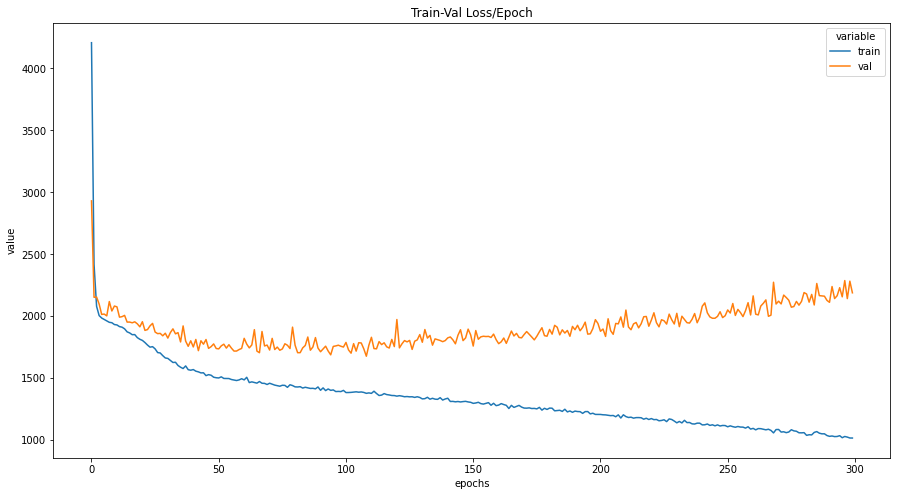

In [151]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [152]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [153]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [154]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 1869.701144728248
R^2 : 0.4007045328591635
